# AFL Time Series Data Analysis with Result and AFL Fantasy Predictions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind, zscore

%matplotlib inline

#Supresses scientific notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("stats.csv")

df.head()

,Team,Player,D.O.B,Height,Weight,Position,Season,Round,Date,Score,...,FreesAgainst,BrownlowVotes,ContendedPossessions,UncontendedPossessions,ContestedMarks,MarksInside50,OnePercenters,Bounces,GoalAssists,PercentPlayed
0,Adelaide,"Atkins, Rory",1994-07-12,186,85,Midfield,2018,R1,2018-03-23,87.00,...,0,0,4,9,0,0,0,0,1,86
1,Adelaide,"Betts, Eddie",1986-11-26,174,74,Forward,2018,R1,2018-03-23,87.00,...,0,0,6,9,0,1,3,0,1,85
2,Adelaide,"Brown, Luke",1992-09-22,181,81,Defender,2018,R1,2018-03-23,87.00,...,0,0,1,10,0,0,2,0,0,82
3,Adelaide,"Crouch, Matt",1995-04-21,182,80,Midfield,2018,R1,2018-03-23,87.00,...,1,0,11,31,0,0,0,0,1,80
4,Adelaide,"Doedee, Tom",1997-03-01,188,88,Defender,2018,R1,2018-03-23,87.00,...,0,0,8,14,0,0,9,1,0,93


In [3]:
df.dtypes

Team                       object
Player                     object
D.O.B                      object
Height                      int64
Weight                      int64
Position                   object
Season                      int64
Round                      object
Date                       object
Score                     float64
Margin                    float64
WinLoss                    object
Opposition                 object
Venue                      object
Disposals                   int64
Kicks                       int64
Marks                       int64
Handballs                   int64
Goals                       int64
Behinds                     int64
Hitouts                     int64
Tackles                     int64
Rebound50s                  int64
Inside50s                   int64
Clearances                  int64
Clangers                    int64
FreesFor                    int64
FreesAgainst                int64
BrownlowVotes               int64
ContendedPosse

### Creating "Age" column:

In [4]:
#Converting date objects to datetime:
df['D.O.B'] = pd.to_datetime(df['D.O.B'], format='%Y'+'-'+'%m'+'-'+'%d')
df['Date'] = pd.to_datetime(df['Date'], format='%Y'+'-'+'%m'+'-'+'%d')

#Creating Age column:
df.insert(2,'Age',(df['Date']-df['D.O.B'])/np.timedelta64(1,'Y'))

df.drop('D.O.B',axis=1,inplace=True)

#Changing WinLoss to numerical values
df.WinLoss.replace(['W', 'L', 'D'],[1,0,.5],inplace=True)

### Fixing Null Values:

In [5]:
#Removing post season "Rounds" (they also have null values)
round_list = ['QF', 'SF', 'PF', 'GF', 'EF']
df = df[~df.Round.isin(round_list)]

### Creating a alphabetically sorted "Team, Opposition" column to be able to group by game:

In [6]:
df['Teams'] = df[['Team','Opposition']].values.tolist()

In [7]:
df.Teams = df.Teams.apply(sorted).apply(', '.join)

### Creating Points Per Percent Played column:

In [8]:
#Creating "points per percent of game played" columns
df.insert(10, 'PointsPerPercentPlayed',(df['Goals']+df['Behinds'])/df['PercentPlayed'])

## Feature info:

In [9]:
df.describe()

,Age,Height,Weight,Season,Score,PointsPerPercentPlayed,Margin,WinLoss,Disposals,Kicks,...,FreesAgainst,BrownlowVotes,ContendedPossessions,UncontendedPossessions,ContestedMarks,MarksInside50,OnePercenters,Bounces,GoalAssists,PercentPlayed
count,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,...,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00,60940.00
mean,24.96,187.76,88.07,2015.00,88.53,0.01,0.00,0.50,16.73,9.43,...,0.84,0.14,6.40,10.28,0.49,0.53,2.15,0.38,0.40,81.81
std,3.68,7.20,8.08,2.00,27.81,0.02,46.17,0.50,7.21,4.56,...,0.98,0.55,3.71,5.31,0.85,0.99,2.33,0.93,0.68,13.32
min,18.27,167.00,67.00,2012.00,17.00,0.00,-162.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
25%,22.07,183.00,82.00,2013.00,69.00,0.00,-30.00,0.00,11.00,6.00,...,0.00,0.00,4.00,6.00,0.00,0.00,1.00,0.00,0.00,79.00
50%,24.61,187.00,86.00,2015.00,86.00,0.00,0.00,0.50,16.00,9.00,...,1.00,0.00,6.00,10.00,0.00,0.00,1.00,0.00,0.00,84.00
75%,27.49,193.00,93.00,2017.00,106.00,0.02,30.00,1.00,21.00,12.00,...,1.00,0.00,8.00,14.00,1.00,1.00,3.00,0.00,1.00,89.00
max,41.26,211.00,118.00,2018.00,193.00,0.25,162.00,1.00,54.00,36.00,...,8.00,3.00,32.00,40.00,8.00,13.00,25.00,15.00,6.00,100.00


In [10]:
number_list = df.select_dtypes(include=['number']).columns

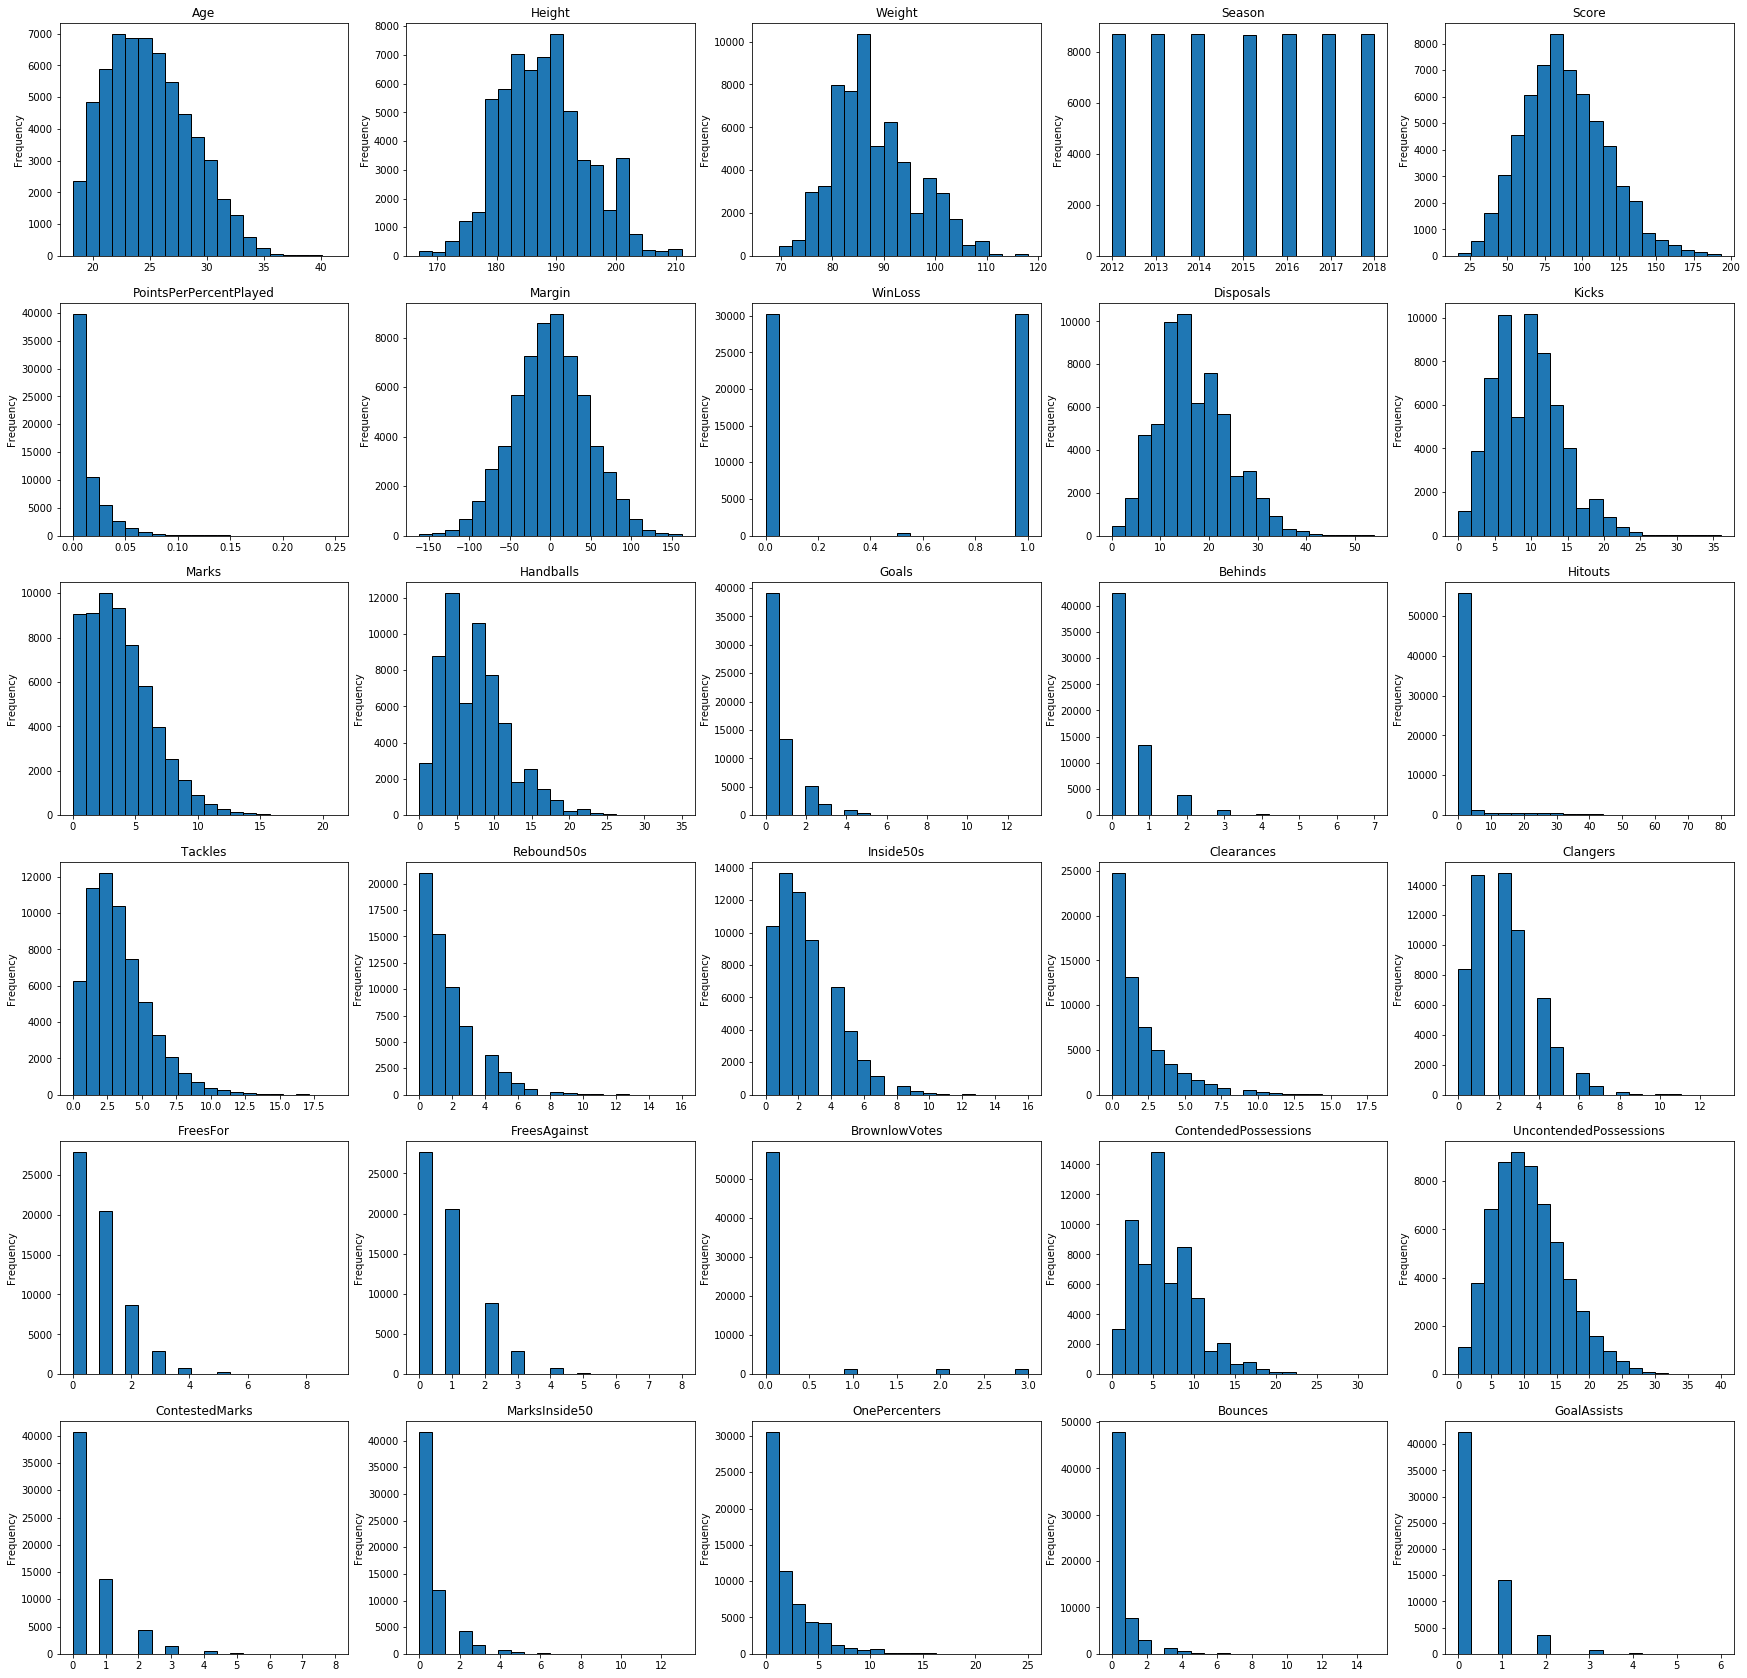

In [11]:
fig,ax = plt.subplots(6, 5)

m=0
for i in range(6):
    for j in range(5):

        df[number_list[m]].plot(kind='hist',bins=20,ax=ax[i,j],figsize=(30, 30),
                                edgecolor='k').set_title(number_list[m])
        m+=1

In [12]:
df = df.set_index(['Season','Round']).sort_index()

## Normalizing all players by round (n1):

In [13]:
df_ML = df.copy()

In [14]:
scaling_list = ['PointsPerPercentPlayed','Disposals', 'Kicks', 'Marks','Handballs',
                'Goals', 'Behinds','Hitouts', 'Tackles', 'Rebound50s','Inside50s',
                'Clearances','Clangers', 'FreesFor', 'FreesAgainst','BrownlowVotes',
                'ContendedPossessions', 'UncontendedPossessions','ContestedMarks',
                'MarksInside50', 'OnePercenters', 'Bounces', 'GoalAssists']

normalize_list = ['Age', 'Height', 'Weight', 'Score', 'Margin']

#Copying lists for AFL Fantasy analysis below:
new_scaling_list = scaling_list.copy()
new_normalize_list = normalize_list.copy()


lose = ['Age', 'Height', 'Weight'] #For rows that I don't want to shift

In [15]:
templist=[]
for col in scaling_list:
    df_ML[col+'_n1'] = df_ML.groupby(['Season','Round'])[col].transform(lambda x:(x.astype(float) - min(x))/(max(x)-min(x)))    
    templist.append(col+'_n1')

scaling_list += templist

In [16]:
templist=[]
for col in normalize_list:
    df_ML[col+'_n1'] = df_ML.groupby(['Season','Round'])[col].transform(lambda x: zscore(x,ddof=1))
    templist.append(col+'_n1')
    
    if col.startswith('Age')|col.startswith('Height')|col.startswith('Weight'):
        lose.append(col+'_n1')

normalize_list += templist

## Normalizing further by game (n2):

In [17]:
df_ML = df_ML.set_index(['Teams'],append=1).sort_index()

In [18]:
templist=[]
for col in scaling_list:
    df_ML[col+'_n2'] = df_ML.groupby(['Season','Round','Teams'])[col].transform(lambda x:(x.astype(float) - min(x))/(max(x)-min(x)))
    templist.append(col+'_n2')

scaling_list += templist

In [19]:
templist=[]
for col in normalize_list:
    df_ML[col+'_n2'] = df_ML.groupby(['Season','Round','Teams'])[col].transform(lambda x: zscore(x,ddof=1))
    templist.append(col+'_n2')
    
    if col.startswith('Age')|col.startswith('Height')|col.startswith('Weight'):
        lose.append(col+'_n2')

normalize_list += templist

In [20]:
df_ML.fillna(0,inplace=True)

# Comparing points made per percent of game to various characteristics relative to players in each game:

In [21]:
df_ML.reset_index(inplace=True)
df_ML.drop(['Season','Round'],axis=1,inplace=True)

df_ML.set_index(['Date','Teams','Team'],inplace=True)
df_ML.sort_index(inplace=True)

## Scaling the data by the percent played:

In [22]:
templist=[]
for col in scaling_list:
    df_ML[col+'scale'] = df_ML[col].multiply(df_ML.PercentPlayed/100,axis=0)
    templist.append(col+'scale')
    
scaling_list += templist

In [23]:
number_list = scaling_list+normalize_list

In [24]:
df_ML[number_list] = df_ML[number_list].groupby(['Date','Teams','Team']).mean()

## Offsetting columns for time series analysis:

In [25]:
df_ML.reset_index(inplace=True)
df_ML.drop(['Player','Position','PercentPlayed','Teams'],axis=1,inplace=True)
df_ML.drop_duplicates(inplace=True)

In [26]:
lose #Columns whose rows that I don't want to shift

['Age',
 'Height',
 'Weight',
 'Age_n1',
 'Height_n1',
 'Weight_n1',
 'Age_n2',
 'Height_n2',
 'Weight_n2',
 'Age_n1_n2',
 'Height_n1_n2',
 'Weight_n1_n2']

In [27]:
Offset_List = number_list + ['WinLoss']

for x in lose:
    Offset_List.remove(x)

In [28]:
PointsList=[]

for column_name in Offset_List:
    for i in range(1):
        df_ML[column_name+'exp'+str(i+5)] = df_ML.set_index('Date',append=1).sort_index(level=1)\
            .groupby('Team')[column_name].rolling(window=i+5,min_periods=i+5,win_types='exponential')\
            .mean().groupby('Team').shift().reset_index(['Team','Date'], drop=1)

        PointsList.append(column_name+'exp'+str(i+5))

In [29]:
Offset_List.remove('WinLoss')

df_ML.drop(Offset_List,axis=1,inplace=True)

In [30]:
#Fixing nulls again because of shifting:
df_ML.dropna(inplace=True)

## Win and Loss Distributions of Features:

In [31]:
df_ML_win = df_ML.select_dtypes(include=['number'])[df_ML.WinLoss==1]

In [32]:
df_ML_loss = df_ML.select_dtypes(include=['number'])[df_ML.WinLoss==0]

In [33]:
number_list = df_ML_win.columns
len(number_list)

206

### Checking distribution differences between winners and losers via hypothesis testing:

In [34]:
series_list=[]

for m in range(206):
    test_stat1, p_value1 = ttest_ind(df_ML_win[number_list[m]], df_ML_loss[number_list[m]])
    
    series_list.append([number_list[m], test_stat1])

df_stat = pd.DataFrame(series_list, columns=['column_name','test_stat_mean'])
df_stat.set_index('column_name',inplace=True)
df_stat.replace([np.inf, -np.inf], np.nan,inplace=True)

In [35]:
df_stat.dropna().abs().sort_values('test_stat_mean',ascending=False)['test_stat_mean'].head(20)

column_name
Age_n2                         19.56
Age_n1_n2                      19.56
Marginexp5                     13.57
Margin_n1exp5                  13.55
Age_n1                         13.18
Inside50sscaleexp5             12.92
Age                            12.88
Inside50sexp5                  12.79
Margin_n2exp5                  12.56
Score_n2exp5                   12.56
Margin_n1_n2exp5               12.56
WinLossexp5                    12.56
Score_n1_n2exp5                12.53
Score_n1exp5                   11.42
Scoreexp5                      11.25
Inside50s_n1exp5               11.24
Inside50s_n1scaleexp5          11.23
BrownlowVotesscaleexp5         11.17
BrownlowVotes_n1_n2scaleexp5   11.17
BrownlowVotes_n1scaleexp5      11.17
Name: test_stat_mean, dtype: float64

### Based on the appearance of the distributions, it seems that the most important features in determining a win are Age, Brownlow Votes, Goal Assists, and previous Points per Percent Played. 

# Machine Learning:
## Making dummy variables:

In [36]:
df_ML.select_dtypes(include=['object']).head()

,Team,Opposition,Venue
1980,Collingwood,Western Bulldogs,Docklands
2002,Western Bulldogs,Collingwood,Docklands
2024,Adelaide,Sydney,S.C.G.
2046,Sydney,Adelaide,S.C.G.
2068,Brisbane Lions,Essendon,Docklands


In [37]:
categorical_list = df_ML.select_dtypes(include=['object']).columns

In [38]:
df_ML = pd.get_dummies(df_ML,columns=categorical_list,drop_first=True)

In [39]:
df_ML = df_ML[df_ML.WinLoss!=.5]

### Alternating between dropping wins and losses to remove one team from each game:

In [40]:
row_list=[]
for row in range(len(df_ML)):
    if (row % 2!=0) & (df_ML.WinLoss.iloc[row]==0):
        row_list.append(df_ML.index[row])
    elif (row % 2==0) & (df_ML.WinLoss.iloc[row]!=0):
        row_list.append(df_ML.index[row])

In [41]:
df_ML.drop(row_list,inplace=True)

In [42]:
df_ML.WinLoss.value_counts()

1.00    715
0.00    715
Name: WinLoss, dtype: int64

## Spliting Data and Creating Model:

In [43]:
X = df_ML.drop(['WinLoss','Date'],axis=1)
y = df_ML['WinLoss']

In [44]:
from sklearn.linear_model import LogisticRegression

#for function below
from sklearn.model_selection import StratifiedKFold
from time import time
from sklearn.metrics import make_scorer,confusion_matrix,accuracy_score,\
    precision_score,recall_score,f1_score,roc_auc_score,matthews_corrcoef

In [45]:
def metrics_function(target,pred):
    return accuracy_score(target, pred),precision_score(target, pred),\
        recall_score(target, pred),f1_score(target, pred),\
        roc_auc_score(target, pred),matthews_corrcoef(target, pred)

def STRAT_TEST(clf,X_all,y_all,folds_num,row_factor):
    start=time()
    
    SFLD=StratifiedKFold(n_splits=folds_num,random_state=0,shuffle=True)
    print ('{}:'.format(clf.__class__.__name__),'\n')
    
    acc_list_train=[]
    acc_list_test=[]
    prc_list_train=[]
    prc_list_test=[]
    rcal_list_train=[]
    rcal_list_test=[]
    f1_list_train=[]
    f1_list_test=[]
    matt_list_train=[]
    matt_list_test=[]
    AUC_list_train=[]
    AUC_list_test=[]
    
    samp_size=X_all.shape[0]//row_factor
    
    for fold,(train_index,target_index) in enumerate(SFLD.split(X_all[:samp_size],
                                                                y_all[:samp_size])):
        X_train=X_all.iloc[train_index].values
        y_train=y_all.iloc[train_index].values

        X_test=X_all.iloc[target_index].values
        y_test=y_all.iloc[target_index].values
        
        clf.fit(X_train,y_train)
        y_pred1=clf.predict(X_train)
        y_pred2=clf.predict(X_test)

        train_acc,train_prc,train_rcal,train_f1,train_auc,train_matt=metrics_function(y_train,y_pred1)
        
        test_acc,test_prc,test_rcal,test_f1,test_auc,test_matt=metrics_function(y_test,y_pred2)
        
        acc_list_train.append(train_acc)
        acc_list_test.append(test_acc)
        prc_list_train.append(train_prc)
        prc_list_test.append(test_prc)
        rcal_list_train.append(train_rcal)
        rcal_list_test.append(test_rcal)
        
        f1_list_train.append(train_f1)
        f1_list_test.append(test_f1)
        matt_list_train.append(train_matt)
        matt_list_test.append(test_matt)
        AUC_list_train.append(train_auc)
        AUC_list_test.append(test_auc)
    
    print("Averages:"'\n')
    
    print("Train acc: {}, Test acc: {}".format(np.mean(acc_list_train),
                                               np.mean(acc_list_test)))
    print("Train prc: {}, Test prc: {}".format(np.mean(prc_list_train),
                                               np.mean(prc_list_test)))
    print("Train recall: {}, Test recall: {}".format(np.mean(rcal_list_train),
                                                     np.mean(rcal_list_test)),'\n')
    
    print("Train f1: {}, Test f1: {}".format(np.mean(f1_list_train),
                                             np.mean(f1_list_test)))
    print("Train MattCC: {}, Test MattCC: {}".format(np.mean(matt_list_train),
                                                     np.mean(matt_list_test)))
    print("Train AUC: {}, Test AUC: {}".format(np.mean(AUC_list_train),
                                               np.mean(AUC_list_test)),'\n'*2)
        
    print("Sample Size: {}, Folds Num: {}, Time: {}".format(samp_size,folds_num,
                                                            time()-start),'\n'*2)

In [46]:
clf_A = LogisticRegression(penalty='l1',tol=1e-1,C=.15,solver='liblinear',random_state=0)

In [47]:
STRAT_TEST(clf_A, X, y, 7, 1)

LogisticRegression: 

Averages:

Train acc: 0.930885513531133, Test acc: 0.9181488129232276
Train prc: 0.9262352981011546, Test prc: 0.9132667008576848
Train recall: 0.9363643771809975, Test recall: 0.9244513339316309 

Train f1: 0.9312641674763283, Test f1: 0.9186917793393664
Train MattCC: 0.8618380108845127, Test MattCC: 0.836608388186983
Train AUC: 0.930885513531133, Test AUC: 0.9181488129232276 


Sample Size: 1430, Folds Num: 7, Time: 0.2578403949737549 




### Previous win percentage of odds favorites from 2009-2013
(according to https://www.bigfooty.com/forum/threads/how-often-do-favourites-win.1004437/)

##### In 2009 it was 50/72 or 69.4% - (only data available)
##### In 2010 it was 109/176 or 61.9%
##### In 2011 it was 142/187 or 75.9%
##### In 2012 it was 155/198 or 78.2%
##### So far in 2013 it was 41/54 or 75.9%

### This model predicts the winner over 90% of the time.

# Predicting AFL Fantasy points:

In [48]:
df_F = df.copy()
fantasy_points = {'Kicks':3,'Handballs':2,'Marks':3,'Tackles':4,'FreesFor':1,
                  'FreesAgainst':-3,'Hitouts':1,'Goals':6,'Behinds':1}

In [49]:
new_list=[]

#Creating fantasy columns
for keys in fantasy_points.keys():
    df_F[keys+'_fantasy'] = df_F[keys]*fantasy_points[keys]
    new_list.append(keys+'_fantasy')
    
df_F['fantasy_points'] = pd.Series()   
    
for cols in fantasy_points.keys():
    df_F.fantasy_points = df_F.fantasy_points.add(df_F[cols+'_fantasy'],fill_value=0)

df_F['target'] = df_F.fantasy_points

In [50]:
df_F[new_list+['fantasy_points']].head()

Kicks_fantasy  Handballs_fantasy  Marks_fantasy  \
Season Round                                                    
2012   R1                42                  8             15   
       R1                39                 24              9   
       R1                15                 24             12   
       R1                42                 10             18   
       R1                15                  6              3   

              Tackles_fantasy  FreesFor_fantasy  FreesAgainst_fantasy  \
Season Round                                                            
2012   R1                  20                 0                    -3   
       R1                   8                 0                    -3   
       R1                  12                 2                     0   
       R1                  28                 2                     0   
       R1                   4                 0                     0   

              Hitouts_fantasy  Goals_fantasy  Behinds_fantasy  fantasy_points  
Season Round                                                                   
2012   R1                   0             12                5           99.00  
       R1                   0             12                0           89.00  
       R1                   0              0                0           65.00  
       R1                   0              6                3          109.00  
       R1                   0              0                0           28.00

In [51]:
df_F.insert(11, 'FantasyPerPercentPlayed',df_F['fantasy_points']/df_F['PercentPlayed'])

In [52]:
df_F.drop(new_list,axis=1,inplace=True)
new_scaling_list = new_scaling_list + ['fantasy_points'] + ['FantasyPerPercentPlayed']

## Fantasy points by position:

In [53]:
print(df_F.Position.value_counts())

hist_names = df_F.Position.value_counts().index.drop('Midfield, Ruck')

Defender              20950
Forward               15047
Midfield              14970
Midfield, Forward      4216
Ruck                   3111
Forward, Ruck          1099
Defender, Midfield      775
Defender, Forward       771
Midfield, Ruck            1
Name: Position, dtype: int64


In [54]:
for names in hist_names:
    print(names+':','\n')
    print(df_F[df_F.Position==names].fantasy_points.describe(),'\n'*2)

Defender: 

count   20950.00
mean       64.59
std        24.83
min        -3.00
25%        47.00
50%        63.00
75%        80.00
max       189.00
Name: fantasy_points, dtype: float64 


Forward: 

count   15047.00
mean       66.19
std        25.39
min        -3.00
25%        49.00
50%        65.00
75%        83.00
max       204.00
Name: fantasy_points, dtype: float64 


Midfield: 

count   14970.00
mean       83.18
std        28.56
min         0.00
25%        64.00
50%        83.00
75%       102.00
max       195.00
Name: fantasy_points, dtype: float64 


Midfield, Forward: 

count   4216.00
mean      76.58
std       26.72
min        0.00
25%       58.00
50%       76.00
75%       94.00
max      187.00
Name: fantasy_points, dtype: float64 


Ruck: 

count   3111.00
mean      76.55
std       26.09
min       -1.00
25%       59.00
50%       76.00
75%       94.00
max      177.00
Name: fantasy_points, dtype: float64 


Forward, Ruck: 

count   1099.00
mean      68.30
std       25.71
min    

### There is a commonly held belief that, in AFL Fantasy, midfielders are the best position for points, and this information confirms that.

## Normalizing all players by round (n1):

In [55]:
templist=[]
for col in new_scaling_list:
    df_F[col+'_n1'] = df_F.groupby(['Season','Round'])[col].transform(lambda x:(x.astype(float) - min(x))/(max(x)-min(x)))    
    templist.append(col+'_n1')

new_scaling_list += templist

In [56]:
templist=[]
for col in new_normalize_list:
    df_F[col+'_n1'] = df_F.groupby(['Season','Round'])[col].transform(lambda x: zscore(x,ddof=1))
    templist.append(col+'_n1')

new_normalize_list += templist

## Normalizing further by game (n2):

In [57]:
df_F = df_F.set_index(['Teams'],append=1).sort_index()

In [58]:
templist=[]
for col in new_scaling_list:
    df_F[col+'_n2'] = df_F.groupby(['Season','Round','Teams'])[col].transform(lambda x:(x.astype(float) - min(x))/(max(x)-min(x)))
    templist.append(col+'_n2')

new_scaling_list += templist

In [59]:
templist=[]
for col in new_normalize_list:
    df_F[col+'_n2'] = df_F.groupby(['Season','Round','Teams'])[col].transform(lambda x: zscore(x,ddof=1))
    templist.append(col+'_n2')

new_normalize_list += templist

In [60]:
df_F.fillna(0,inplace=True)

# Comparing points made per percent of game to various characteristics relative to players in each game:

In [61]:
df_F.reset_index(inplace=True)
df_F.drop(['Season','Round'],axis=1,inplace=True)

df_F = df_F.set_index(['Date','Teams','Team']).sort_index()

## Scaling the data by the percent played:

In [62]:
templist=[]
for col in new_scaling_list:
    df_F[col+'scale'] = df_F[col].multiply(df_F.PercentPlayed/100,axis=0)
    templist.append(col+'scale')
    
new_scaling_list += templist

In [63]:
new_number_list = new_scaling_list+new_normalize_list

## Offsetting columns for time series analysis:

In [64]:
df_F.reset_index(inplace=True)
df_F.drop(['Teams','PercentPlayed'],axis=1,inplace=True)

In [65]:
Offset_Fantasy_List = new_number_list + ['WinLoss']

for x in lose:
    Offset_Fantasy_List.remove(x)

### Creating a 5-game exponentially weighted moving average:

In [66]:
FantasyList=[]

for column_name in Offset_Fantasy_List:  
    for i in range(1):
        df_F[column_name+'exp'+str(i+5)] = df_F.set_index('Date',append=1).sort_index(level=1)\
            .groupby('Player')[column_name].rolling(window=i+5,min_periods=i+5,win_types='exponential')\
            .mean().groupby('Player').shift().reset_index(['Player','Date'], drop=1)

        FantasyList.append(column_name+'exp'+str(i+5))

In [67]:
df_F.drop(Offset_Fantasy_List,axis=1,inplace=True)

In [68]:
#Fixing nulls again because of shifting:
df_F.dropna(inplace=True)

## Correlation Between AFL Fantasy Points and Other Features by Position:

In [69]:
column_list = df_F.select_dtypes(include=['number']).drop('target',axis=1).columns

## Defender:

In [70]:
df_F[df_F.Position=='Defender'][column_list].corrwith(df_F[df_F.Position=='Defender'].target).sort_values(ascending=False)

Disposalsexp5                             0.51
FantasyPerPercentPlayedscaleexp5          0.51
fantasy_pointsexp5                        0.51
Disposals_n1exp5                          0.50
fantasy_points_n1exp5                     0.50
Disposals_n2exp5                          0.50
Disposals_n1_n2exp5                       0.50
FantasyPerPercentPlayed_n2scaleexp5       0.50
FantasyPerPercentPlayed_n1_n2scaleexp5    0.50
fantasy_points_n1_n2exp5                  0.49
fantasy_points_n2exp5                     0.49
FantasyPerPercentPlayedexp5               0.49
Disposalsscaleexp5                        0.48
FantasyPerPercentPlayed_n1scaleexp5       0.48
Disposals_n1scaleexp5                     0.48
FantasyPerPercentPlayed_n1_n2exp5         0.48
FantasyPerPercentPlayed_n2exp5            0.48
Disposals_n2scaleexp5                     0.48
Disposals_n1_n2scaleexp5                  0.48
Kicksexp5                                 0.48
Kicks_n1exp5                              0.47
Kicks_n1_n2ex

## Forward:

In [71]:
df_F[df_F.Position=='Forward'][column_list].corrwith(df_F[df_F.Position=='Forward'].target).sort_values(ascending=False)

FantasyPerPercentPlayedscaleexp5          0.40
fantasy_pointsexp5                        0.40
fantasy_points_n1exp5                     0.39
fantasy_pointsscaleexp5                   0.39
fantasy_points_n1scaleexp5                0.39
fantasy_points_n1_n2exp5                  0.39
fantasy_points_n2exp5                     0.39
fantasy_points_n1_n2scaleexp5             0.39
fantasy_points_n2scaleexp5                0.39
Disposalsscaleexp5                        0.38
FantasyPerPercentPlayed_n1_n2scaleexp5    0.38
FantasyPerPercentPlayed_n2scaleexp5       0.38
Disposals_n1scaleexp5                     0.38
FantasyPerPercentPlayed_n1scaleexp5       0.38
Kicksscaleexp5                            0.38
Kicks_n1scaleexp5                         0.37
Kicksexp5                                 0.37
Kicks_n2scaleexp5                         0.37
Kicks_n1_n2scaleexp5                      0.37
Disposalsexp5                             0.37
Disposals_n1_n2scaleexp5                  0.37
Disposals_n2s

## Midfield:

In [72]:
df_F[df_F.Position=='Midfield'][column_list].corrwith(df_F[df_F.Position=='Midfield'].target).sort_values(ascending=False)

FantasyPerPercentPlayedscaleexp5         0.50
fantasy_pointsexp5                       0.50
Disposalsexp5                            0.49
fantasy_points_n1exp5                    0.49
Disposalsscaleexp5                       0.49
fantasy_pointsscaleexp5                  0.49
Disposals_n1exp5                         0.49
fantasy_points_n1scaleexp5               0.48
FantasyPerPercentPlayed_n2scaleexp5      0.48
FantasyPerPercentPlayed_n1_n2scaleexp5   0.48
Disposals_n1scaleexp5                    0.48
fantasy_points_n2exp5                    0.48
fantasy_points_n1_n2exp5                 0.48
Disposals_n1_n2exp5                      0.48
Disposals_n2exp5                         0.48
Disposals_n1_n2scaleexp5                 0.47
Disposals_n2scaleexp5                    0.47
fantasy_points_n2scaleexp5               0.47
fantasy_points_n1_n2scaleexp5            0.47
FantasyPerPercentPlayed_n1scaleexp5      0.47
FantasyPerPercentPlayedexp5              0.45
FantasyPerPercentPlayed_n2exp5    

## Midfield, Forward:

In [73]:
df_F[df_F.Position=='Midfield, Forward'][column_list].corrwith(df_F[df_F.Position=='Midfield, Forward'].target).sort_values(ascending=False)

FantasyPerPercentPlayedscaleexp5         0.47
fantasy_pointsexp5                       0.47
fantasy_points_n1exp5                    0.46
Disposalsexp5                            0.45
fantasy_pointsscaleexp5                  0.45
FantasyPerPercentPlayed_n2scaleexp5      0.45
FantasyPerPercentPlayed_n1_n2scaleexp5   0.45
fantasy_points_n2exp5                    0.45
fantasy_points_n1_n2exp5                 0.45
Disposals_n1exp5                         0.45
Disposalsscaleexp5                       0.45
Disposals_n1_n2exp5                      0.45
Disposals_n2exp5                         0.45
Disposals_n1scaleexp5                    0.45
Disposals_n1_n2scaleexp5                 0.45
Disposals_n2scaleexp5                    0.45
fantasy_points_n1scaleexp5               0.45
fantasy_points_n2scaleexp5               0.44
fantasy_points_n1_n2scaleexp5            0.44
FantasyPerPercentPlayed_n1scaleexp5      0.44
FantasyPerPercentPlayedexp5              0.42
ContendedPossessionsscaleexp5     

## Ruck:

In [74]:
df_F[df_F.Position=='Ruck'][column_list].corrwith(df_F[df_F.Position=='Ruck'].target).sort_values(ascending=False)

FantasyPerPercentPlayedscaleexp5          0.45
fantasy_pointsexp5                        0.45
fantasy_pointsscaleexp5                   0.44
fantasy_points_n1exp5                     0.44
fantasy_points_n1scaleexp5                0.44
FantasyPerPercentPlayed_n1_n2scaleexp5    0.43
FantasyPerPercentPlayed_n2scaleexp5       0.43
FantasyPerPercentPlayed_n1scaleexp5       0.43
fantasy_points_n2exp5                     0.43
fantasy_points_n1_n2exp5                  0.43
fantasy_points_n1_n2scaleexp5             0.42
fantasy_points_n2scaleexp5                0.42
FantasyPerPercentPlayedexp5               0.41
FantasyPerPercentPlayed_n2exp5            0.39
FantasyPerPercentPlayed_n1_n2exp5         0.39
FantasyPerPercentPlayed_n1exp5            0.39
Disposalsscaleexp5                        0.39
Hitoutsscaleexp5                          0.38
Disposalsexp5                             0.38
Disposals_n1scaleexp5                     0.37
Hitoutsexp5                               0.37
Hitouts_n1sca

## Forward, Ruck:

In [75]:
df_F[df_F.Position=='Forward, Ruck'][column_list].corrwith(df_F[df_F.Position=='Forward, Ruck'].target).sort_values(ascending=False)

FantasyPerPercentPlayedscaleexp5          0.41
fantasy_pointsexp5                        0.41
fantasy_points_n1exp5                     0.40
fantasy_points_n2exp5                     0.40
fantasy_points_n1_n2exp5                  0.40
FantasyPerPercentPlayed_n1_n2scaleexp5    0.40
FantasyPerPercentPlayed_n2scaleexp5       0.40
FantasyPerPercentPlayedexp5               0.40
fantasy_pointsscaleexp5                   0.39
fantasy_points_n1_n2scaleexp5             0.39
fantasy_points_n2scaleexp5                0.39
FantasyPerPercentPlayed_n1_n2exp5         0.39
FantasyPerPercentPlayed_n2exp5            0.39
FantasyPerPercentPlayed_n1scaleexp5       0.38
fantasy_points_n1scaleexp5                0.38
Disposalsexp5                             0.38
Age_n2                                    0.37
Age_n1_n2                                 0.37
FantasyPerPercentPlayed_n1exp5            0.37
Age_n1                                    0.37
Disposals_n2exp5                          0.37
Disposals_n1_

## Defender, Midfield:

In [76]:
df_F[df_F.Position=='Defender, Midfield'][column_list].corrwith(df_F[df_F.Position=='Defender, Midfield'].target).sort_values(ascending=False)

Disposals_n1scaleexp5                     0.47
Disposals_n1exp5                          0.46
Disposalsscaleexp5                        0.46
fantasy_points_n1scaleexp5                0.45
fantasy_points_n1exp5                     0.45
Disposals_n1_n2scaleexp5                  0.45
Disposals_n2scaleexp5                     0.45
fantasy_pointsscaleexp5                   0.45
Disposalsexp5                             0.45
FantasyPerPercentPlayedscaleexp5          0.45
fantasy_pointsexp5                        0.45
Disposals_n1_n2exp5                       0.44
Disposals_n2exp5                          0.44
fantasy_points_n2scaleexp5                0.44
fantasy_points_n1_n2scaleexp5             0.44
fantasy_points_n2exp5                     0.44
fantasy_points_n1_n2exp5                  0.44
FantasyPerPercentPlayed_n2scaleexp5       0.42
FantasyPerPercentPlayed_n1_n2scaleexp5    0.42
FantasyPerPercentPlayed_n1scaleexp5       0.42
Kicks_n1scaleexp5                         0.41
Kicksscaleexp

## Defender, Forward:

In [77]:
df_F[df_F.Position=='Defender, Forward'][column_list].corrwith(df_F[df_F.Position=='Defender, Forward'].target).sort_values(ascending=False)

fantasy_pointsscaleexp5                   0.41
Kicksexp5                                 0.41
Kicksscaleexp5                            0.41
fantasy_points_n1scaleexp5                0.41
fantasy_pointsexp5                        0.41
FantasyPerPercentPlayedscaleexp5          0.41
Disposalsexp5                             0.40
Disposalsscaleexp5                        0.40
fantasy_points_n1exp5                     0.40
Disposals_n1exp5                          0.40
fantasy_points_n2scaleexp5                0.40
fantasy_points_n1_n2scaleexp5             0.40
Kicks_n1exp5                              0.40
Disposals_n1scaleexp5                     0.40
Kicks_n1scaleexp5                         0.40
fantasy_points_n1_n2exp5                  0.39
fantasy_points_n2exp5                     0.39
FantasyPerPercentPlayed_n1scaleexp5       0.39
Kicks_n2scaleexp5                         0.39
Kicks_n1_n2scaleexp5                      0.39
Kicks_n2exp5                              0.39
Kicks_n1_n2ex

# Machine Learning:
## Making dummy variables:

In [78]:
df_F.select_dtypes(include=['object']).head()

,Team,Player,Position,Opposition,Venue
1983,Collingwood,"Clarke, Martin",Defender,Western Bulldogs,Docklands
1984,Collingwood,"Cloke, Travis",Forward,Western Bulldogs,Docklands
1985,Collingwood,"Dawes, Chris",Forward,Western Bulldogs,Docklands
1986,Collingwood,"Fasolo, Alex",Forward,Western Bulldogs,Docklands
1987,Collingwood,"Goldsack, Tyson",Defender,Western Bulldogs,Docklands


In [79]:
categorical_list2 = df_F.select_dtypes(include=['object']).drop('Player',axis=1).columns

In [80]:
df_F = pd.get_dummies(df_F,columns=categorical_list2,drop_first=True)

## Spliting Data and Creating Model:

In [81]:
X2 = df_F.drop(['target','Date','Player'],axis=1)
y2 = df_F['target']

In [82]:
from sklearn.linear_model import Ridge

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

In [83]:
clf_A = Ridge(alpha=1e3,random_state=0)

In [84]:
def metrics_function(target,pred):
    return mean_squared_error(target,pred),mean_absolute_error(target,pred),r2_score(target,pred)

def FOLD_TEST(clf,X_all,y_all,folds_num,row_factor):
    start=time()
    
    KFLD=KFold(n_splits=folds_num,random_state=0,shuffle=True)
    print ('{}:'.format(clf.__class__.__name__),'\n')
    
    samp_size=X_all.shape[0]//row_factor
    
    MSE_list_train=[]
    MSE_list_test=[]
    MAE_list_train=[]
    MAE_list_test=[]
    R2_list_train=[]
    R2_list_test=[]
    
    for fold,(train_index,target_index) in enumerate(KFLD.split(X_all[:samp_size],
                                                                y_all[:samp_size])):
        X_train=X_all.iloc[train_index].values
        y_train=y_all.iloc[train_index].values

        X_test=X_all.iloc[target_index].values
        y_test=y_all.iloc[target_index].values
        
        clf.fit(X_train,y_train)
        y_pred1=clf.predict(X_train)
        y_pred2=clf.predict(X_test)

        train_MSE,train_MAE,train_R2=metrics_function(y_train,y_pred1)
        test_MSE,test_MAE,test_R2=metrics_function(y_test,y_pred2)
        
        MSE_list_train.append(train_MSE)
        MSE_list_test.append(test_MSE)
        MAE_list_train.append(train_MAE)
        MAE_list_test.append(test_MAE)
        R2_list_train.append(train_R2)
        R2_list_test.append(test_R2)
        
    print("Train MSE: {}, Test MSE: {}".format(np.mean(MSE_list_train),
                                               np.mean(MSE_list_test)),'\n'*2) 
    print("Train MAE: {}, Test MAE: {}".format(np.mean(MAE_list_train),
                                               np.mean(MAE_list_test)),'\n'*2)
    print("Train R2: {}, Test R2: {}".format(np.mean(R2_list_train),
                                             np.mean(R2_list_test)),'\n'*2)   
        
    print("Sample Size: {}, Folds Num: {}, Time: {}".format(samp_size,folds_num,
                                                            time()-start),'\n'*2)

In [85]:
FOLD_TEST(clf_A, X2, y2, 7, 1)

Ridge: 

Train MSE: 507.0207612600552, Test MSE: 508.5873221842143 


Train MAE: 17.7161027302842, Test MAE: 17.743126703242496 


Train R2: 0.3140354126895707, Test R2: 0.311859329772468 


Sample Size: 55135, Folds Num: 7, Time: 2.7573044300079346 


